In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import numpy as np 
import warnings
import shapely
import rasterio
from pathlib import Path
import os
import pandas as pd
warnings.filterwarnings("ignore")
def read_gpkg(fnm,layer='perimeter'):
    ''' read gpkg data
    op: 'perimeter', 'fireline', 'newfirepix'
    '''

    gdf = gpd.read_file(fnm,layer=layer)

    return gdf

In [283]:
# Path to your GeoPackage file
gpkg_path = "Largefire/LargeFires_2020.gpkg"

# List all layers in the GeoPackage
layers = fiona.listlayers(gpkg_path)
print("Layers in GeoPackage:", layers)

# List to hold the data from each file
dataframes = []
# Loop through each file and read the data
for file in Path.cwd().glob("Largefire/*.gpkg"):
    # Assuming you want to read the same layer from each GeoPackage
    # Replace 'your_layer_name' with the actual name of the layer you want to read
    if os.path.exists(file):
        gdf = gpd.read_file(file, layer='perimeter')
        dataframes.append(gdf)

# Combine all GeoDataFrames into one
combined_gdf = pd.concat(dataframes, ignore_index=True)


Layers in GeoPackage: ['perimeter', 'fireline', 'newfirepix']


In [291]:
filtered_gdf = (combined_gdf[combined_gdf['fireID'] == 3649])
filtered_gdf

,time,clat,clon,ftype,n_pixels,n_newpixels,farea,fperim,flinelen,duration,...,year,tst_month,tst_day,tst_ampm,ted_year,ted_month,ted_day,ted_ampm,fireID,geometry
2947,2020-08-20T12:00:00,36.160976,-118.443184,4,1,1,0.141000,0.013118,0.013118,0.5,...,2020,8,20,PM,2020,8,20,PM,3649,"POLYGON ((-118.44110 36.16098, -118.44111 36.1..."
2948,2020-08-21T00:00:00,36.162431,-118.444714,4,6,5,0.769093,0.033134,0.033134,1.0,...,2020,8,20,PM,2020,8,21,AM,3649,"POLYGON ((-118.44114 36.16055, -118.44116 36.1..."
2949,2020-08-21T12:00:00,36.162762,-118.442268,4,18,12,2.328019,0.056469,0.055486,1.5,...,2020,8,20,PM,2020,8,21,PM,3649,"POLYGON ((-118.44955 36.15896, -118.44959 36.1..."
2950,2020-08-22T00:00:00,36.163335,-118.444110,4,36,18,3.622446,0.070975,0.070975,2.0,...,2020,8,20,PM,2020,8,22,AM,3649,"POLYGON ((-118.43564 36.16870, -118.43560 36.1..."
2951,2020-08-22T12:00:00,36.163335,-118.444110,4,36,0,3.622446,0.070975,0.000000,2.0,...,2020,8,20,PM,2020,8,22,AM,3649,"POLYGON ((-118.43564 36.16870, -118.43560 36.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3100,2020-11-05T00:00:00,36.235496,-118.541396,2,19330,21,946.292377,2.514277,0.080426,77.0,...,2020,8,20,PM,2020,11,5,AM,3649,"POLYGON ((-118.50712 36.23239, -118.50710 36.2..."
3101,2020-11-05T12:00:00,36.235521,-118.541377,2,19340,10,946.476103,2.514329,0.061022,77.5,...,2020,8,20,PM,2020,11,5,PM,3649,"POLYGON ((-118.50712 36.23239, -118.50710 36.2..."
3102,2020-11-06T00:00:00,36.235524,-118.541373,2,19344,4,946.537701,2.514726,0.028373,78.0,...,2020,8,20,PM,2020,11,6,AM,3649,"POLYGON ((-118.50712 36.23239, -118.50710 36.2..."
3103,2020-11-06T12:00:00,36.235526,-118.541370,2,19345,1,946.576296,2.514772,0.018573,78.5,...,2020,8,20,PM,2020,11,6,PM,3649,"POLYGON ((-118.50712 36.23239, -118.50710 36.2..."


In [292]:
fires = []
areas = []
for x in combined_gdf['fireID'].unique():
    fires.append(combined_gdf[combined_gdf['fireID'] == x])
for y in fires:
    areas.append(y['farea'].max())
avg = sum(areas) / len(areas)
print(avg)
# def calculate_average_area(dataframes):
#     return dataframes['farea'].mean()
# avg = calculate_average_area(combined_gdf)


69.14668780499089


In [293]:
grid_size = 224  # 224x224 grid
total_pixels = grid_size ** 2  # Total number of pixels in the grid

# Assuming the area is in square degrees (modify this if the unit is different)
pixel_area = avg / total_pixels / 250
pixel_size = np.sqrt(pixel_area)  # Since area = size^2
pixel_size


0.0023478355174728605

In [294]:
def adjust_bounds_to_fixed_resolution(df, pixel_size, grid_size=224):
    minx, miny, maxx, maxy = df.total_bounds

    # Calculate new spans based on pixel size and grid size
    new_lon_span = pixel_size * grid_size
    new_lat_span = pixel_size * grid_size

    # Center the new spans around the current center
    center_lon = (minx + maxx) / 2
    center_lat = (miny + maxy) / 2
    new_minx = center_lon - new_lon_span / 2
    new_maxx = center_lon + new_lon_span / 2
    new_miny = center_lat - new_lat_span / 2
    new_maxy = center_lat + new_lat_span / 2

    return new_minx, new_miny, new_maxx, new_maxy

def create_mesh_grid(minx, miny, maxx, maxy, grid_size=224):
    # Calculate the spans for longitude and latitude

    # Generate x and y coordinates
    x_coords = np.linspace(minx, maxx, grid_size)
    y_coords = np.linspace(miny, maxy, grid_size)

    # Create a mesh grid
    xx, yy = np.meshgrid(x_coords, y_coords)

    return xx, yy

def create_frames(df,grid):
    frames = []
    # shape = df.iloc[10]
    # geometry = shape['geometry']  
    # points = [geometry.contains(shapely.Point(x, y)) for x, y in zip(grid[0].ravel(), grid[1].ravel())]
    # raster = np.array(points)
    # raster = raster.reshape(xx.shape)
    # frames.append(raster)
    for index, shape in df.iterrows():
        geometry = shape['geometry']
        points = [geometry.contains(shapely.Point(x, y)) for x, y in zip(grid[0].ravel(), grid[1].ravel())]
        raster = np.array(points)
        raster = raster.reshape(xx.shape)
        frames.append(raster)
        print(index)
        

    return frames

2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104


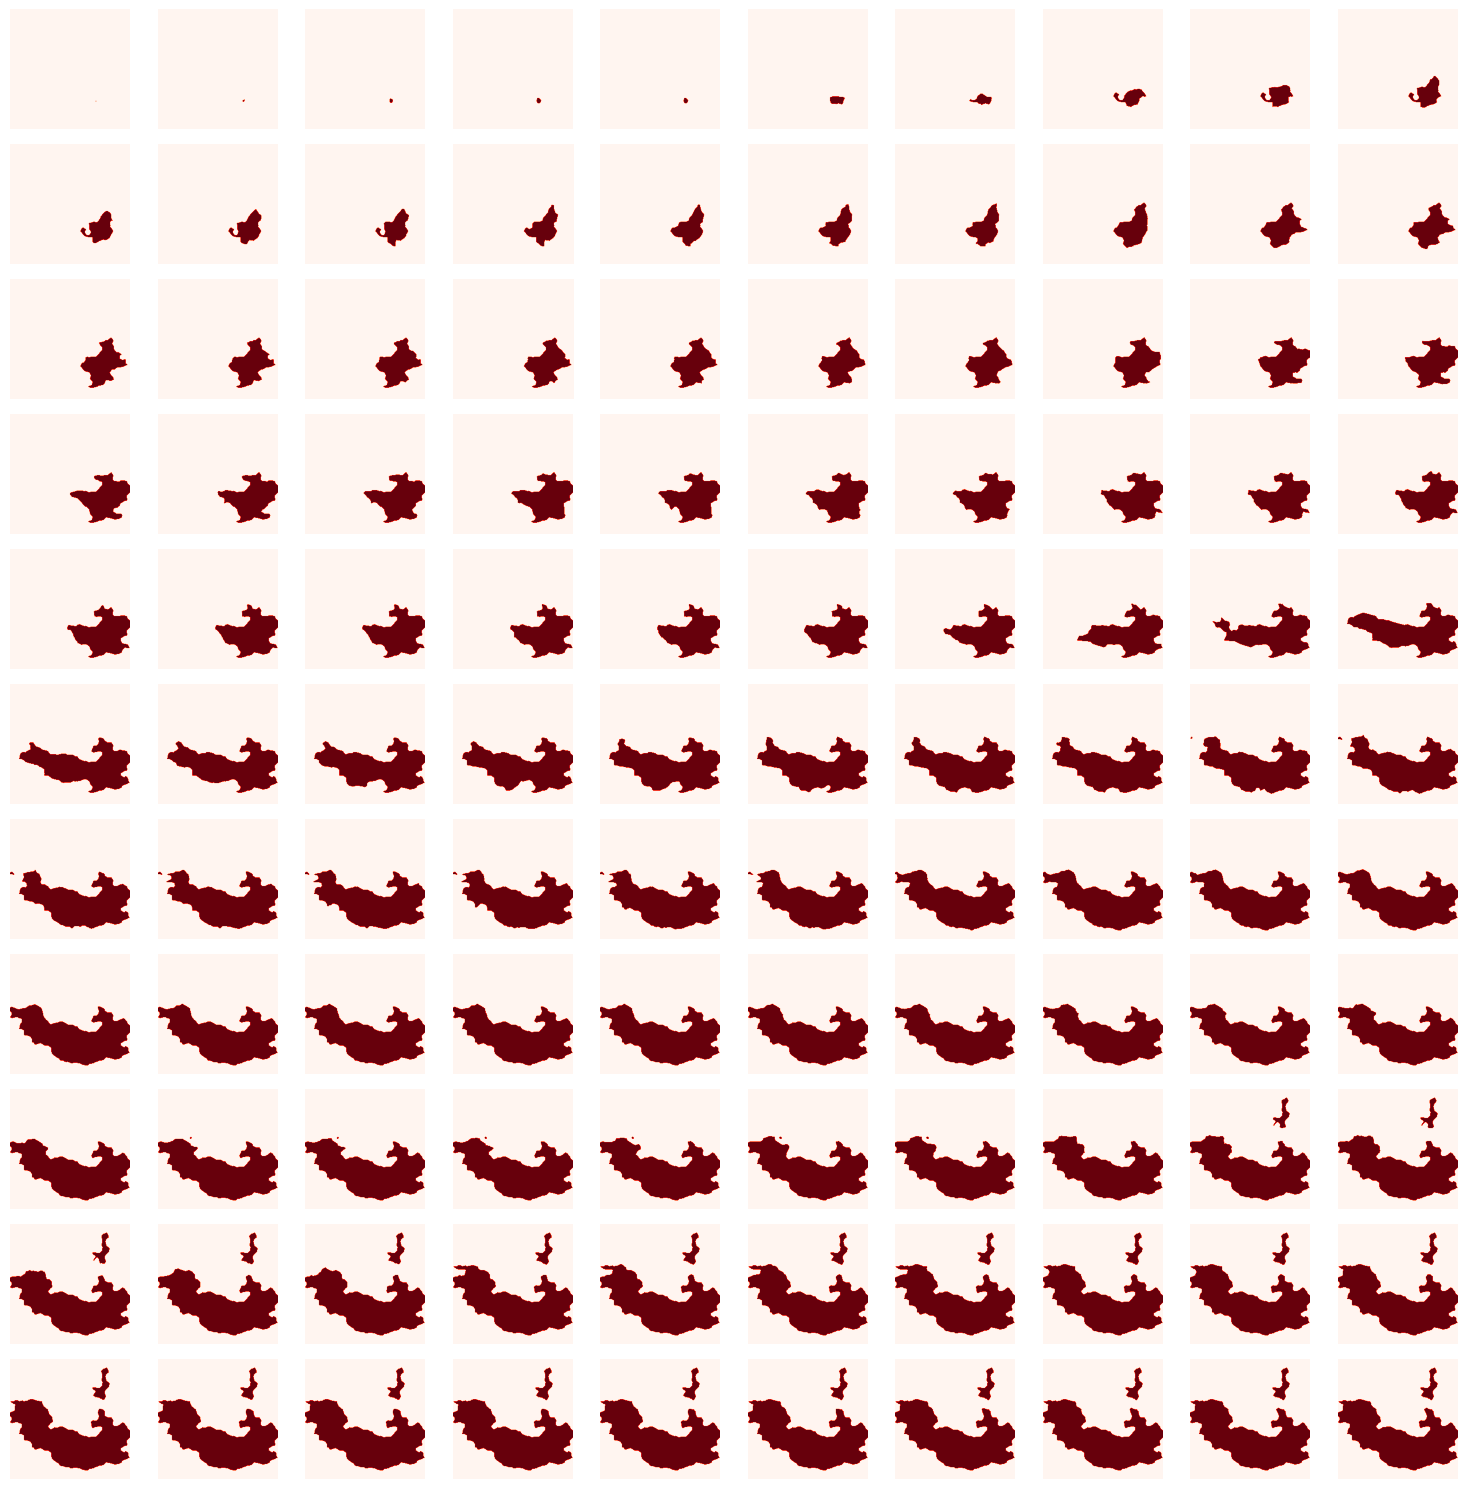

In [295]:
minx, miny, maxx, maxy = adjust_bounds_to_fixed_resolution(filtered_gdf, pixel_size)
frames = create_frames(filtered_gdf,create_mesh_grid(minx, miny, maxx, maxy))

plot_selected_images(frames)



In [270]:
# Specify the fireID you want to filter by
# specific_fireID = 3649
specific_fireID = 16
  # Replace with the fireID you are interested in

# Filter rows that match the specific fireID
filtered_gdf = (combined_gdf[combined_gdf['fireID'] == specific_fireID])

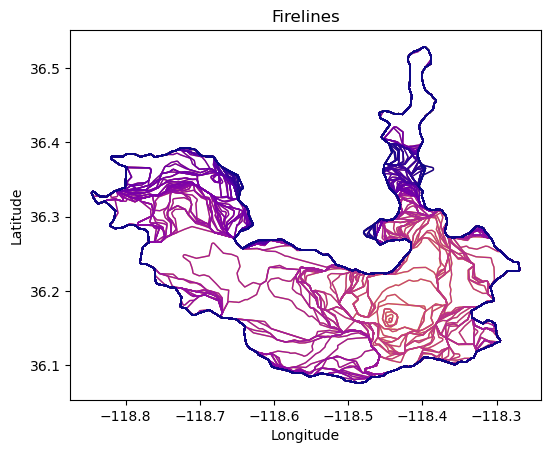

In [4]:

# Create a color map
num_rows = len(filtered_gdf)
colors = plt.cm.plasma(np.linspace(0, 1, num_rows))[::-1]

# Plot each row with a different color
fig, ax = plt.subplots()
for i,(idx, row )in enumerate(filtered_gdf.iterrows()):
    row_gdf = gpd.GeoDataFrame([row], columns=filtered_gdf.columns)
    row_gdf.plot(ax=ax,edgecolor=colors[i],facecolor='none',label=f'Fireline {i+1}')
    

# Setting the title and labels
ax.set_title('Firelines')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

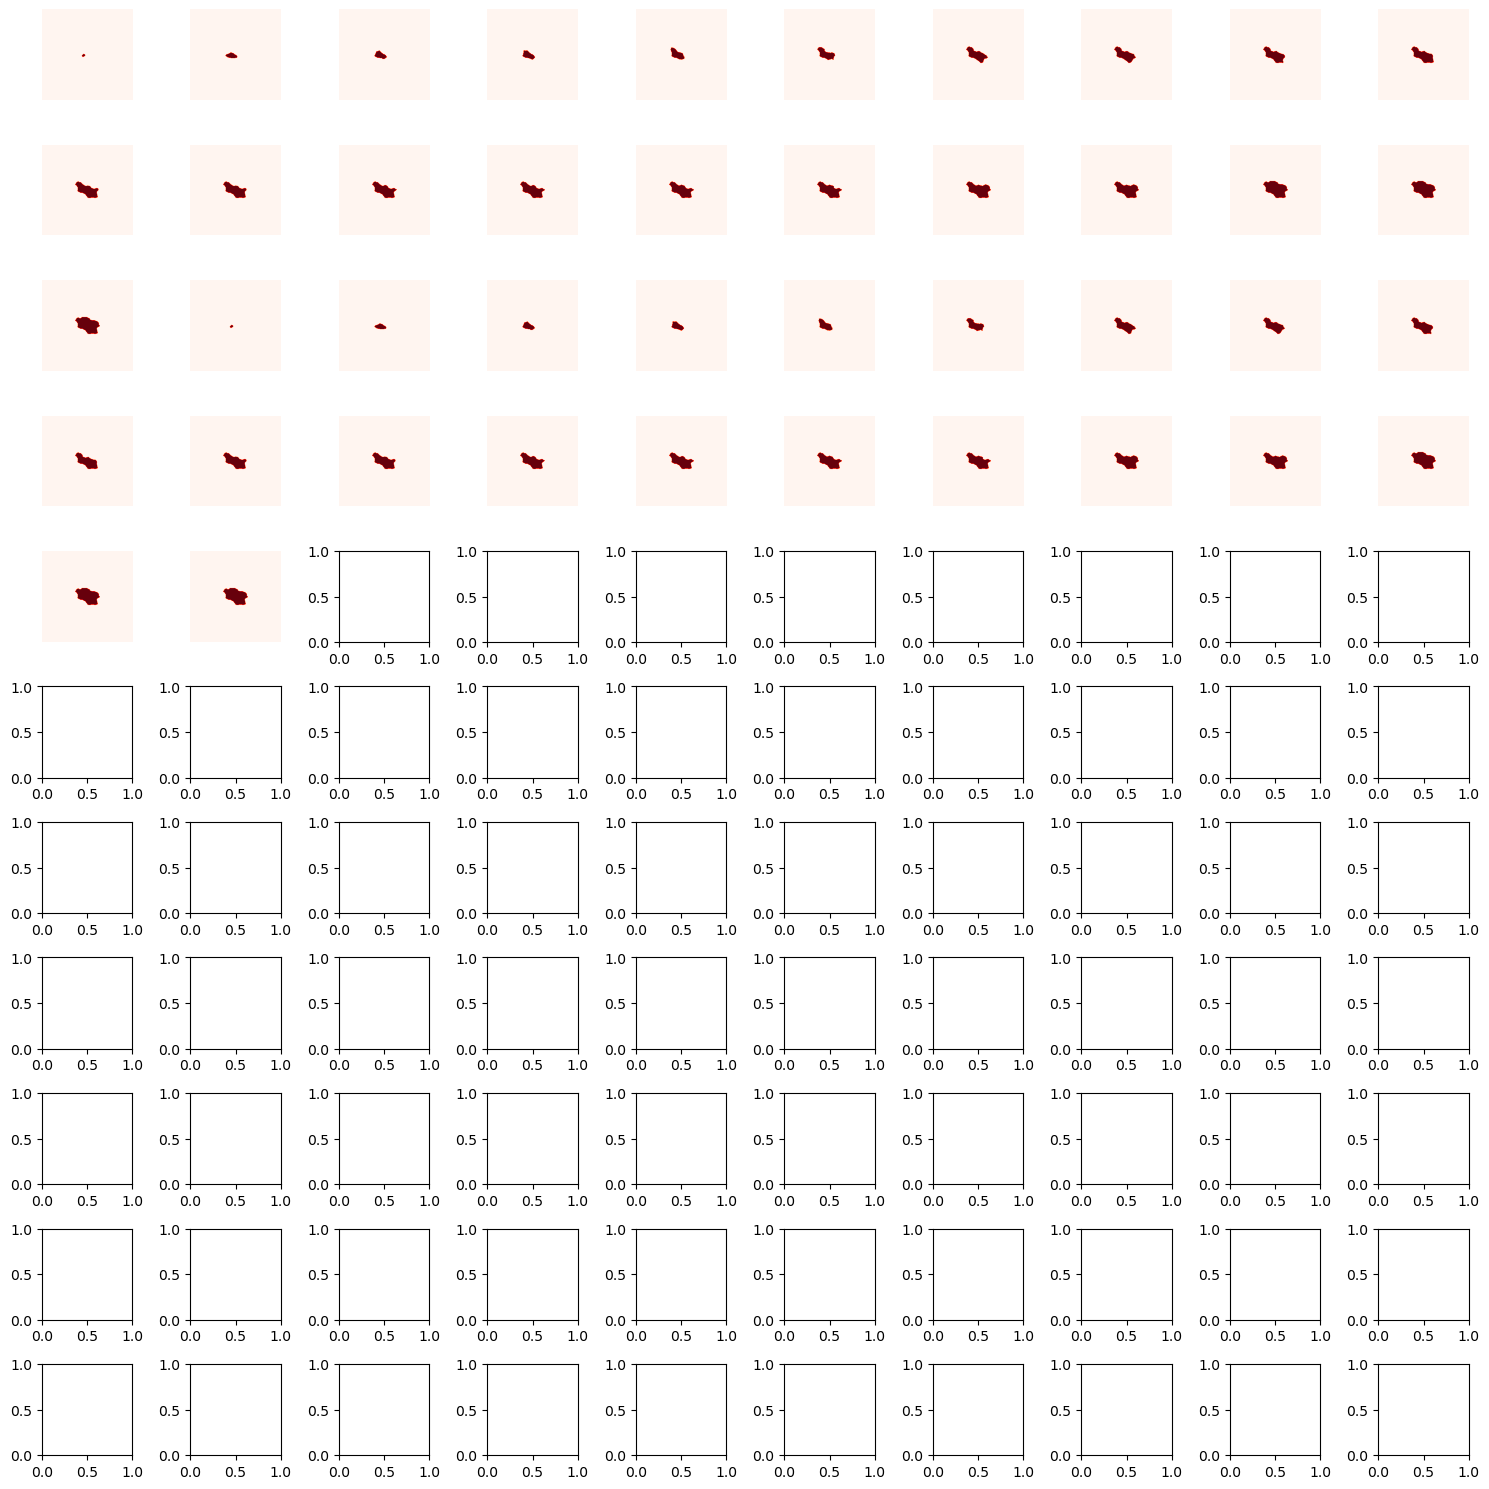

In [261]:
def plot_selected_images(images_list):
    # Define the grid size for 20 images (e.g., 5x4)
    rows = 11
    cols = 10

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    # Iterate over the images and the axes to plot each image
    for ax, img in zip(axes.flatten(), images_list):
        ax.imshow(img,origin='lower', cmap='Reds')
        ax.axis('off')  # Hide the axes

    plt.tight_layout()
    plt.show()

plot_selected_images(frames)


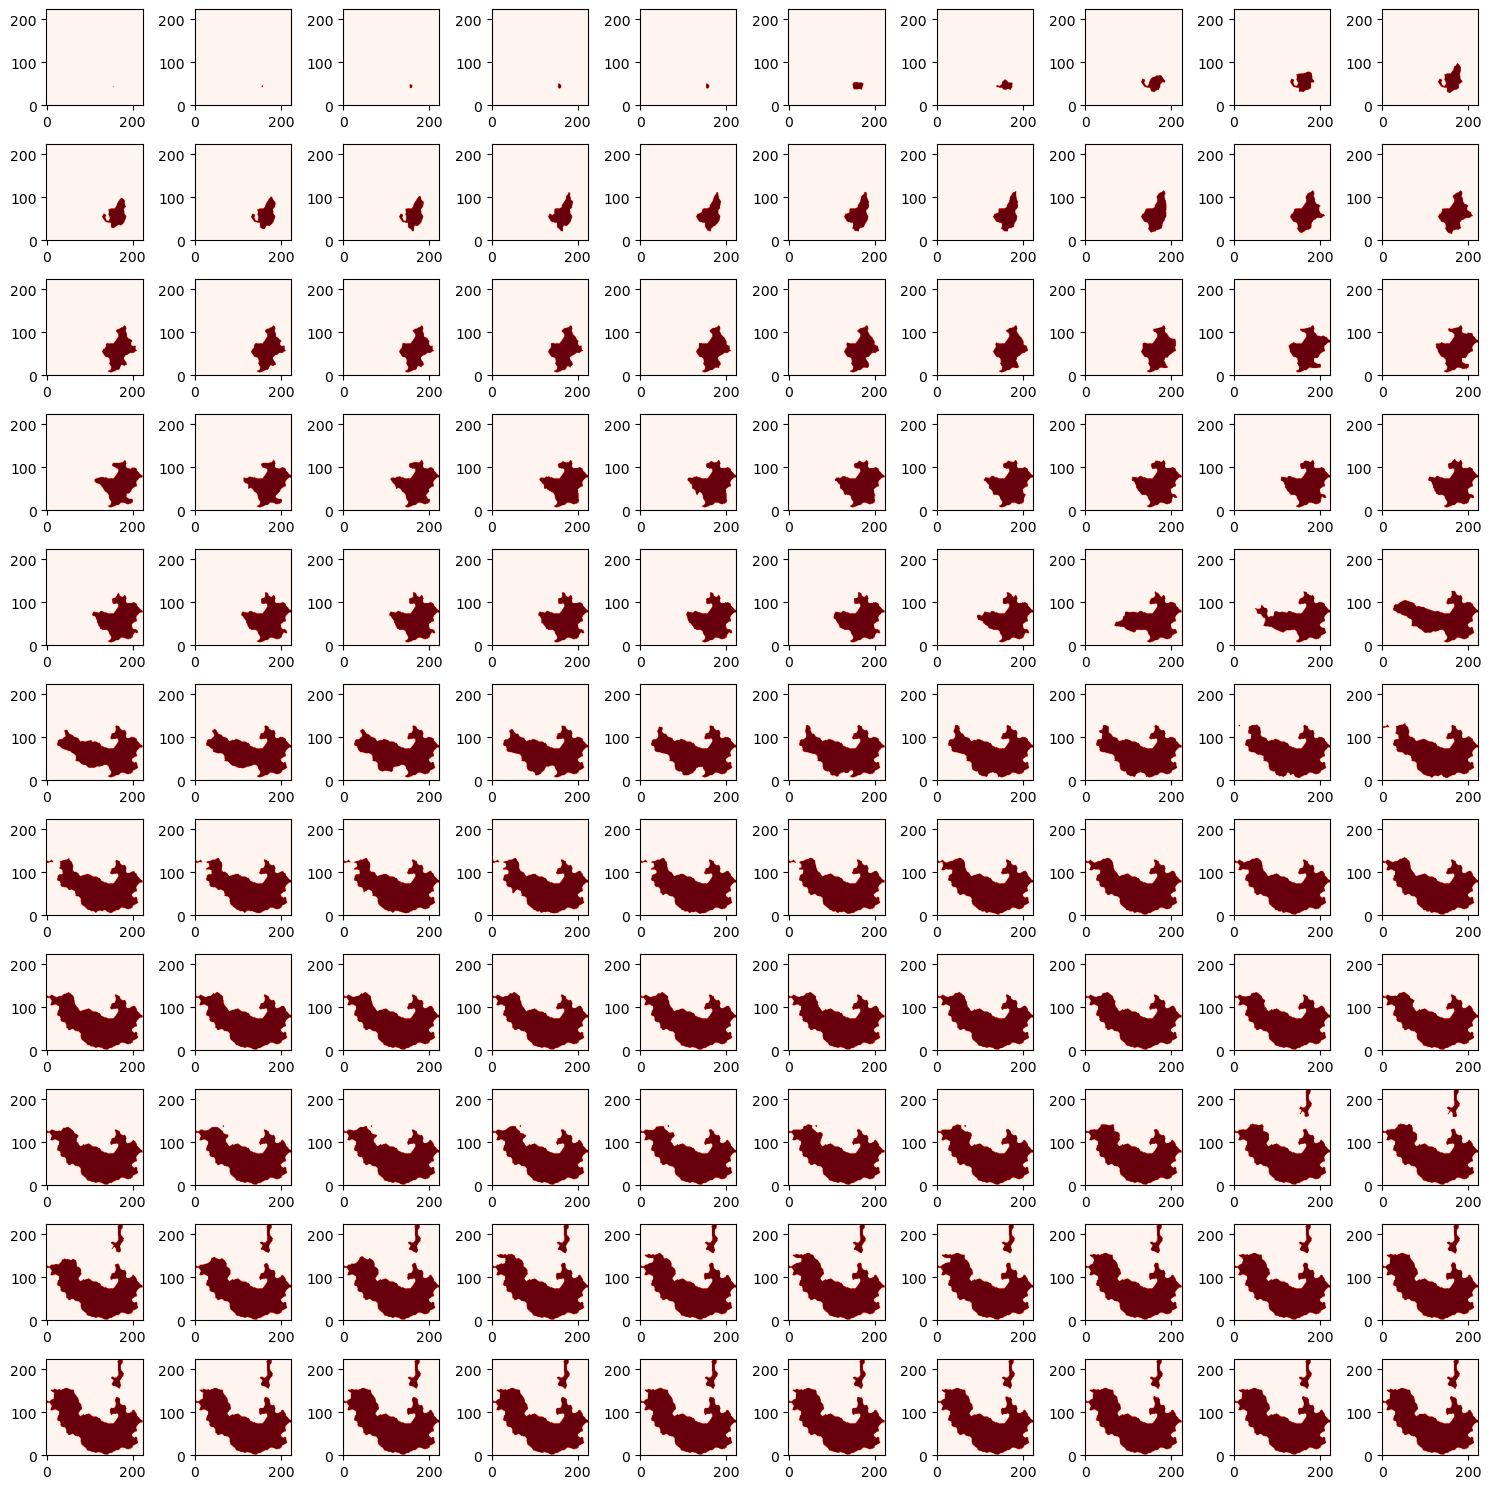

In [76]:
import pickle

with open('fire_frames.pkl', 'wb') as f:
    pickle.dump(frames, f)

new_frames = None
with open('fire_frames.pkl', 'rb') as f:
    new_frames = pickle.load(f)

plot_selected_images(new_frames)


In [22]:
import netCDF4 # import libraries

In [85]:
from datetime import datetime
from netCDF4 import num2date, date2num


2020-11-07T00:00:00


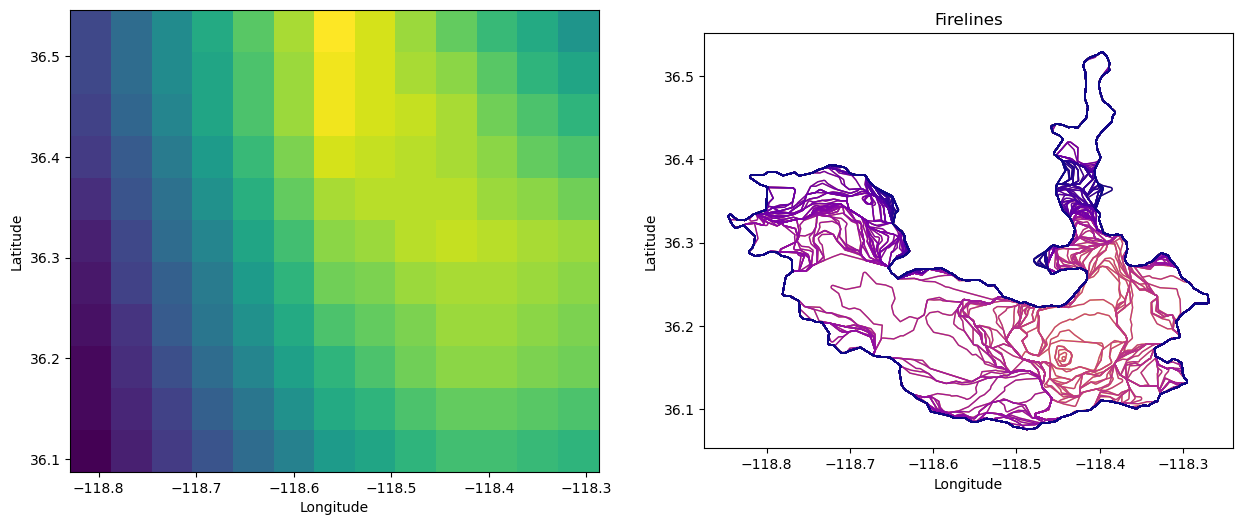

In [89]:
your_date = datetime.strptime(filtered_gdf['time'].iloc[1], '%Y-%m-%dT%H:%M:%S')  # Example date in YYYY-MM-DD format
reference_date = datetime.strptime('1900-01-01', '%Y-%m-%d')
days_since_ref = (your_date - reference_date).days

# Load the 'day' variable from the NetCDF file
nc_dataset = netCDF4.Dataset(nc_file_path, mode='r')
days = nc_dataset.variables['day'][:]

# Find the index of the closest day
closest_day_index = np.abs(days - days_since_ref).argmin()


# Extracting longitude, latitude, and wind speed data
lon = nc_dataset.variables['lon'][:]
lat = nc_dataset.variables['lat'][:]
wind_speed = nc_dataset.variables['wind_speed'][:]  # Assuming wind_speed has a day dimension

# Specify the day you are interested in
specific_day_index = 0  # Replace with the index of the day you want to plot

# Extract wind speed data for the specific day
wind_speed_day = wind_speed[closest_day_index, :, :]

# Close the NetCDF file
nc_dataset.close()

# Create boolean masks for filtering
lon_mask = (lon >= minx) & (lon <= maxx)
lat_mask = (lat >= miny) & (lat <= maxy)

# Filter the wind speed data
wind_speed_filtered = wind_speed_day[np.ix_(lat_mask, lon_mask)]

# Plot wind speed data on the first subplot
# Create a meshgrid for plotting
lon_filtered = lon[lon_mask]
lat_filtered = lat[lat_mask]
LON, LAT = np.meshgrid(lon_filtered, lat_filtered)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting
axs[0].pcolormesh(LON, LAT, wind_speed_filtered, shading='auto')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
# Create a color map
num_rows = len(filtered_gdf)
colors = plt.cm.plasma(np.linspace(0, 1, num_rows))[::-1]

# Plot each row with a different color
for i,(idx, row )in enumerate(filtered_gdf.iterrows()):
    row_gdf = gpd.GeoDataFrame([row], columns=filtered_gdf.columns)
    row_gdf.plot(ax=axs[1],edgecolor=colors[i],facecolor='none',label=f'Fireline {i+1}')
    

# Setting the title and labels
axs[1].set_title('Firelines')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
plt.show()

In [93]:
landcover_file = "/Users/jmacshane/Downloads/usa_land_cover_2020_30m_tif/ASK_NALCMS_landcover_2020_30m/data/ASK_NALCMS_landcover_2020_30m.tif"

In [99]:
from PIL import Image
from rasterio.windows import Window

min_x, min_y, max_x, max_y = 100, 100, 300, 300

with rasterio.open(landcover_file) as src:
    # Calculate the window position
    window = Window.from_slices((min_y, max_y), (min_x, max_x))

    # Read the data from the window
    cropped_image = src.read(window=window)

    # Save the cropped image to a new file
    with rasterio.open(
        'cropped_image.tif', 
        'w', 
        driver='GTiff',
        height=window.height,
        width=window.width,
        count=src.count,
        dtype=src.dtypes[0],
        crs=src.crs,
        transform=src.window_transform(window)
    ) as dst:
        dst.write(cropped_image)
